In [2]:
import os
import glob
import os.path as osp
import warnings
warnings.filterwarnings(action='ignore')
import multiprocessing
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchsummary import summary

os.chdir('/VOLUME/nia_vent_asynchrony')
from module.datasets import preprocess_data#, set_dataloader, CustomDataset
from module.utils import load_and_stack_data, EarlyStopping
from model.VAE import VAE
from model.AsynchModel import AsynchModel
from module.metrics import calculate_any_metrics
from module.loss import calculate_vae_loss, calculate_bce_loss
import module.utils as cutils


In [3]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2,3" 

In [4]:
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Current cuda device: 0
Count of using GPUs: 2


In [5]:
torch.cuda.is_available()

True

In [6]:
dest_dir = '/VOLUME/nia_vent_asynchrony/data/processed_data/tmp'
done_list = glob.glob(f'{dest_dir}/*.pkl')
print(len(done_list))

done_df = pd.DataFrame({'path': done_list})
done_df['filename'] = done_df['path'].copy().str.replace(dest_dir+'/', '')
done_df = pd.concat([done_df, 
    done_df['filename'].str.split('_').apply(pd.Series).rename(columns={0: 'hospital_id_patient_id', 1: 'wav_number', 2: 'datetime'})], axis=1)
done_df = done_df.sort_values(['hospital_id_patient_id','wav_number','datetime']).groupby(['hospital_id_patient_id','wav_number']).tail(1)
# done_df = done_df.sort_values(['hospital_id_patient_id','wav_number','datetime'])
done_df['hospital_id'] = done_df['hospital_id_patient_id'].str[0]
done_df['patient_id'] = done_df['hospital_id_patient_id'].str[2:]
done_df['patient_id_num'] = done_df['patient_id'].astype(int)
# unique_done_df = done_df.groupby(['hospital_id_patient_id','wav_number']).tail(1)

45928


In [7]:
done_df['hospital_id_patient_id'].drop_duplicates().tolist()

['1-001',
 '1-002',
 '1-003',
 '1-004',
 '1-005',
 '1-006',
 '1-007',
 '1-008',
 '1-009',
 '1-010',
 '1-011',
 '1-012',
 '1-013',
 '1-014',
 '1-015',
 '1-016',
 '1-017',
 '1-018',
 '1-019',
 '1-020',
 '1-021',
 '1-022',
 '1-023',
 '1-024',
 '1-025',
 '1-027',
 '1-029',
 '1-030',
 '1-031',
 '1-032',
 '1-033',
 '1-034',
 '1-035',
 '1-036',
 '1-037',
 '1-038',
 '1-039',
 '1-040',
 '1-041',
 '1-042',
 '1-043',
 '1-044',
 '1-045',
 '1-047',
 '1-048',
 '1-049',
 '1-050',
 '1-051',
 '1-052',
 '1-054',
 '1-055',
 '1-056',
 '1-058',
 '1-059',
 '1-060',
 '1-061',
 '1-062',
 '1-063',
 '1-064',
 '1-065',
 '1-066',
 '1-067',
 '1-068',
 '1-069',
 '1-070',
 '1-071',
 '1-072',
 '1-073',
 '1-075',
 '1-076',
 '1-077',
 '1-078',
 '1-079',
 '1-080',
 '1-081',
 '1-082',
 '1-083',
 '1-084',
 '1-085',
 '1-086',
 '1-089',
 '1-090',
 '1-091',
 '1-092',
 '1-094',
 '1-095',
 '1-096',
 '1-098',
 '1-099',
 '1-100',
 '1-101',
 '1-102',
 '1-103',
 '1-104',
 '1-105',
 '1-106',
 '1-107',
 '1-108',
 '1-109',
 '1-110',


In [8]:
done_df

,path,filename,hospital_id_patient_id,wav_number,datetime,hospital_id,patient_id,patient_id_num
13247,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_1_2022-09-19.pkl,1-001,1,2022-09-19.pkl,1,001,1
13248,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_2_2022-09-19.pkl,1-001,2,2022-09-19.pkl,1,001,1
13249,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_3_2022-09-19.pkl,1-001,3,2022-09-19.pkl,1,001,1
13251,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_4_2022-09-19.pkl,1-001,4,2022-09-19.pkl,1,001,1
13245,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_5_2022-09-19.pkl,1-001,5,2022-09-19.pkl,1,001,1
...,...,...,...,...,...,...,...,...
26152,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_95_2022-09-20.pkl,2-249,95,2022-09-20.pkl,2,249,249
26013,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_96_2022-09-20.pkl,2-249,96,2022-09-20.pkl,2,249,249
26240,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_97_2022-09-20.pkl,2-249,97,2022-09-20.pkl,2,249,249
26120,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_98_2022-09-20.pkl,2-249,98,2022-09-20.pkl,2,249,249


In [9]:
partial_patwav_df = done_df[(done_df.hospital_id=='1')&(done_df.patient_id_num>=201)&(done_df.patient_id_num<=300)]
print(len(partial_patwav_df))

n_cpu = multiprocessing.cpu_count()
n_threads = 20
print(f'no. cpu existed : {n_cpu}, use {n_threads} threads')

pool = multiprocessing.Pool(processes=n_threads)
result = pool.map(pd.read_pickle, partial_patwav_df.path.tolist())
pool.close()
pool.join()

print('aggregate all instances')
dat_infer = pd.concat(result)
dat_infer['wav_number'] = dat_infer['wav_number'].astype(int)
# 1min

2165
no. cpu existed : 104, use 20 threads
aggregate all instances


In [10]:
partial_patwav_df.path.tail().tolist()

['/VOLUME/nia_vent_asynchrony/data/processed_data/tmp/1-300_95_2022-09-20.pkl',
 '/VOLUME/nia_vent_asynchrony/data/processed_data/tmp/1-300_96_2022-09-20.pkl',
 '/VOLUME/nia_vent_asynchrony/data/processed_data/tmp/1-300_97_2022-09-20.pkl',
 '/VOLUME/nia_vent_asynchrony/data/processed_data/tmp/1-300_98_2022-09-20.pkl',
 '/VOLUME/nia_vent_asynchrony/data/processed_data/tmp/1-300_99_2022-09-20.pkl']

In [11]:
print(dat_infer['hospital_id_patient_id'].min(), dat_infer['hospital_id_patient_id'].max(), dat_infer['hospital_id_patient_id'].nunique(),dat_infer['flow_path'].nunique())
dat_infer['hospital_id_patient_id'].nunique(), len(dat_infer[['hospital_id_patient_id','wav_number']].drop_duplicates()), len(dat_infer)

1-201 1-300 100 2024


(100, 2024, 111187)

In [12]:
dat_infer_snu = dat_infer.copy()
del dat_infer

In [13]:
partial_patwav_df = done_df[(done_df.hospital_id=='2')&(done_df.patient_id_num>=92)&(done_df.patient_id_num<=162)]
print(len(partial_patwav_df))

n_cpu = multiprocessing.cpu_count()
n_threads = 20
print(f'no. cpu existed : {n_cpu}, use {n_threads} threads')

pool = multiprocessing.Pool(processes=n_threads)
result = pool.map(pd.read_pickle, partial_patwav_df.path.tolist())
pool.close()
pool.join()

print('aggregate all instances')
dat_infer = pd.concat(result)
dat_infer['wav_number'] = dat_infer['wav_number'].astype(int)

2901
no. cpu existed : 104, use 20 threads
aggregate all instances


In [14]:
dat_infer_aju = dat_infer.copy()
del dat_infer

In [15]:
dat = pd.concat([dat_infer_snu, dat_infer_aju], axis=0)

In [16]:
# 환자당 wav_number 개수
dat[['hospital_id','hospital_id_patient_id','wav_number']].drop_duplicates().groupby(['hospital_id','hospital_id_patient_id']).count().iloc[:,0].to_dict()

{('1', '1-201'): 9,
 ('1', '1-202'): 26,
 ('1', '1-203'): 26,
 ('1', '1-204'): 7,
 ('1', '1-205'): 13,
 ('1', '1-206'): 7,
 ('1', '1-207'): 4,
 ('1', '1-208'): 9,
 ('1', '1-209'): 6,
 ('1', '1-210'): 21,
 ('1', '1-211'): 8,
 ('1', '1-212'): 25,
 ('1', '1-213'): 17,
 ('1', '1-214'): 12,
 ('1', '1-215'): 24,
 ('1', '1-216'): 9,
 ('1', '1-217'): 8,
 ('1', '1-218'): 9,
 ('1', '1-219'): 9,
 ('1', '1-220'): 8,
 ('1', '1-221'): 20,
 ('1', '1-222'): 14,
 ('1', '1-223'): 46,
 ('1', '1-224'): 20,
 ('1', '1-225'): 16,
 ('1', '1-226'): 20,
 ('1', '1-227'): 12,
 ('1', '1-228'): 5,
 ('1', '1-229'): 17,
 ('1', '1-230'): 10,
 ('1', '1-231'): 12,
 ('1', '1-232'): 19,
 ('1', '1-233'): 10,
 ('1', '1-234'): 25,
 ('1', '1-235'): 15,
 ('1', '1-236'): 13,
 ('1', '1-237'): 15,
 ('1', '1-238'): 7,
 ('1', '1-239'): 12,
 ('1', '1-240'): 2,
 ('1', '1-241'): 19,
 ('1', '1-242'): 12,
 ('1', '1-243'): 9,
 ('1', '1-244'): 8,
 ('1', '1-245'): 23,
 ('1', '1-246'): 12,
 ('1', '1-247'): 14,
 ('1', '1-248'): 15,
 ('1', '1

In [17]:
# 환자당 instance 개수
dat.groupby(['hospital_id','hospital_id_patient_id']).count().iloc[:,0].to_dict()

{('1', '1-201'): 361,
 ('1', '1-202'): 1475,
 ('1', '1-203'): 1473,
 ('1', '1-204'): 357,
 ('1', '1-205'): 729,
 ('1', '1-206'): 413,
 ('1', '1-207'): 50,
 ('1', '1-208'): 465,
 ('1', '1-209'): 302,
 ('1', '1-210'): 1123,
 ('1', '1-211'): 371,
 ('1', '1-212'): 1404,
 ('1', '1-213'): 990,
 ('1', '1-214'): 654,
 ('1', '1-215'): 1390,
 ('1', '1-216'): 443,
 ('1', '1-217'): 357,
 ('1', '1-218'): 440,
 ('1', '1-219'): 430,
 ('1', '1-220'): 357,
 ('1', '1-221'): 1178,
 ('1', '1-222'): 738,
 ('1', '1-223'): 2608,
 ('1', '1-224'): 1135,
 ('1', '1-225'): 855,
 ('1', '1-226'): 1023,
 ('1', '1-227'): 713,
 ('1', '1-228'): 224,
 ('1', '1-229'): 857,
 ('1', '1-230'): 377,
 ('1', '1-231'): 631,
 ('1', '1-232'): 899,
 ('1', '1-233'): 586,
 ('1', '1-234'): 1408,
 ('1', '1-235'): 837,
 ('1', '1-236'): 675,
 ('1', '1-237'): 881,
 ('1', '1-238'): 361,
 ('1', '1-239'): 668,
 ('1', '1-240'): 54,
 ('1', '1-241'): 1106,
 ('1', '1-242'): 621,
 ('1', '1-243'): 513,
 ('1', '1-244'): 423,
 ('1', '1-245'): 1311,


In [18]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272181 entries, 0 to 435
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype                                
---  ------                  --------------   -----                                
 0   flow_path               272181 non-null  object                               
 1   starttime               272181 non-null  datetime64[ns, pytz.FixedOffset(540)]
 2   endtime                 272181 non-null  datetime64[ns, pytz.FixedOffset(540)]
 3   data                    272181 non-null  object                               
 4   hospital_id             272181 non-null  object                               
 5   patient_id              272181 non-null  object                               
 6   wav_number              272181 non-null  int64                                
 7   hospital_id_patient_id  272181 non-null  object                               
 8   instance_index          272181 non-null  object 

In [19]:
dat['patient_id_num'] = dat['patient_id'].astype(int)

In [20]:
dat['split'] = 'train'
dat.loc[(dat.hospital_id=='1')&(dat.patient_id_num>=281)&(dat.patient_id_num<=290),'split'] = 'valid'
dat.loc[(dat.hospital_id=='1')&(dat.patient_id_num>=291)&(dat.patient_id_num<=300),'split'] = 'test'
dat.loc[(dat.hospital_id=='2')&(dat.patient_id_num>=132)&(dat.patient_id_num<=138),'split'] = 'valid'
dat.loc[(dat.hospital_id=='2')&(dat.patient_id_num>=139)&(dat.patient_id_num<=162),'split'] = 'test'

In [21]:
dat['split'].value_counts()

train    182565
test      64914
valid     24702
Name: split, dtype: int64

In [22]:
dat['split'].value_counts(normalize=True)

train    0.670749
test     0.238496
valid    0.090756
Name: split, dtype: float64

In [23]:
dat

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,patient_id_num,split
0,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:00:21.613013+09:00,2021-12-21 16:01:21.613013+09:00,"[[-130.0, -10.0], [-130.0, -10.0], [-130.0, -1...",1,201,10,1-201,626470,201,train
7,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:01:21.598746+09:00,2021-12-21 16:02:21.598746+09:00,"[[125.77499389648438, 29.645000457763672], [12...",1,201,10,1-201,626477,201,train
15,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:02:21.615413+09:00,2021-12-21 16:03:21.615413+09:00,"[[-14.95000457763672, 6.034999847412109], [-14...",1,201,10,1-201,626485,201,train
22,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:03:21.601146+09:00,2021-12-21 16:04:21.601146+09:00,"[[-14.235000610351562, 6.004999160766602], [-1...",1,201,10,1-201,626492,201,train
30,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:04:21.617813+09:00,2021-12-21 16:05:21.617813+09:00,"[[-14.7550048828125, 5.944999694824219], [-14....",1,201,10,1-201,626500,201,train
...,...,...,...,...,...,...,...,...,...,...,...
405,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:53:59.992621+09:00,2020-08-07 12:54:59.992621+09:00,"[[629.0, 1947.5], [645.5, 2077.5], [642.5, 215...",2,162,9,2-162,950169,162,test
412,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:54:59.975978+09:00,2020-08-07 12:55:59.975978+09:00,"[[-289.0, 518.0], [-276.5, 517.0], [-263.0, 51...",2,162,9,2-162,950176,162,test
420,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:55:59.992645+09:00,2020-08-07 12:56:59.992645+09:00,"[[535.0, 2152.0], [505.0, 2147.0], [473.0, 214...",2,162,9,2-162,950184,162,test
427,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:56:59.976002+09:00,2020-08-07 12:57:59.976002+09:00,"[[-47.0, 510.0], [-47.0, 510.0], [-47.0, 510.0...",2,162,9,2-162,950191,162,test


In [24]:
# time 변환 timestamp->int
dat['basename'] = dat['flow_path'].str.split('/').str[-1]

In [25]:
timedf = dat[['basename','flow_path']].drop_duplicates()

In [26]:
timedf['wav_firsttime'] = timedf['flow_path'].apply(lambda fi: pd.to_datetime(pd.read_csv(fi, nrows=1)['Time'].iloc[0]))

In [27]:
timedf

,basename,flow_path,wav_firsttime
0,1-201-010.csv,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:00:21.613013+09:00
0,1-201-011.csv,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 17:00:21.574614+09:00
0,1-201-012.csv,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 18:00:21.523844+09:00
0,1-201-013.csv,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 19:00:22.505041+09:00
0,1-201-014.csv,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 20:00:22.403832+09:00
...,...,...,...
0,2-162-074.csv,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-074.csv,2020-08-10 04:59:59.986933+09:00
0,2-162-075.csv,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-075.csv,2020-08-10 05:59:59.987653+09:00
0,2-162-076.csv,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-076.csv,2020-08-10 06:59:59.988373+09:00
0,2-162-008.csv,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-008.csv,2020-08-07 10:59:59.991253+09:00


In [28]:
timedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4925 entries, 0 to 0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype                                
---  ------         --------------  -----                                
 0   basename       4925 non-null   object                               
 1   flow_path      4925 non-null   object                               
 2   wav_firsttime  4925 non-null   datetime64[ns, pytz.FixedOffset(540)]
dtypes: datetime64[ns, pytz.FixedOffset(540)](1), object(2)
memory usage: 153.9+ KB


In [29]:
dat['hospital_id'].value_counts()

2    160994
1    111187
Name: hospital_id, dtype: int64

In [30]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272181 entries, 0 to 435
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype                                
---  ------                  --------------   -----                                
 0   flow_path               272181 non-null  object                               
 1   starttime               272181 non-null  datetime64[ns, pytz.FixedOffset(540)]
 2   endtime                 272181 non-null  datetime64[ns, pytz.FixedOffset(540)]
 3   data                    272181 non-null  object                               
 4   hospital_id             272181 non-null  object                               
 5   patient_id              272181 non-null  object                               
 6   wav_number              272181 non-null  int64                                
 7   hospital_id_patient_id  272181 non-null  object                               
 8   instance_index          272181 non-null  object

In [31]:
# 라벨 붙이기
ann_df = pd.read_csv('/VOLUME/nia_vent_asynchrony/result/baseline_220818/label/아주대_1차_50명(092-162)_result_data_20220920_1.csv')
ann_df = pd.concat([ann_df, 
    pd.read_csv('/VOLUME/nia_vent_asynchrony/result/baseline_220818/label/서울대_1차_100명(201-300)_result_data_20220920_1.csv')])

# ann_df 에 startTime(float) -> starttime(datetime64)

In [32]:
timedf.columns

Index(['basename', 'flow_path', 'wav_firsttime'], dtype='object')

In [33]:
ann_df

,startTime,endTime,duration,label_annotation,csv_name,hospital_id_patient_id,wav_number
0,543.718424,557.139580,13.421156,1,2-105-022.csv,2-105,22
1,1773.633016,1801.868480,28.235464,1,2-105-022.csv,2-105,22
2,2518.314667,2630.485333,112.170667,1,2-092-001.csv,2-092,1
3,0.768000,713.002667,712.234667,3,2-092-001.csv,2-092,1
4,1401.130666,1402.453333,1.322667,2,2-092-001.csv,2-092,1
...,...,...,...,...,...,...,...
12628,1248.008293,1255.991786,7.983493,2,1-300-143.csv,1-300,143
12629,1376.010853,1383.994346,7.983493,2,1-300-143.csv,1-300,143
12630,1408.011493,1415.994986,7.983493,2,1-300-143.csv,1-300,143
12631,1440.012133,1447.995626,7.983493,2,1-300-143.csv,1-300,143


In [34]:
ann_df = pd.merge(ann_df, timedf, left_on='csv_name', right_on='basename') 

In [35]:
ann_df

,startTime,endTime,duration,label_annotation,csv_name,hospital_id_patient_id,wav_number,basename,flow_path,wav_firsttime
0,543.718424,557.139580,13.421156,1,2-105-022.csv,2-105,22,2-105-022.csv,/ext_ssd/nia_vent/aju/2-105/AWF/2-105-022.csv,2019-03-17 20:59:59.998453+09:00
1,1773.633016,1801.868480,28.235464,1,2-105-022.csv,2-105,22,2-105-022.csv,/ext_ssd/nia_vent/aju/2-105/AWF/2-105-022.csv,2019-03-17 20:59:59.998453+09:00
2,548.826835,557.789742,8.962906,1,2-105-022.csv,2-105,22,2-105-022.csv,/ext_ssd/nia_vent/aju/2-105/AWF/2-105-022.csv,2019-03-17 20:59:59.998453+09:00
3,1776.790933,1790.537170,13.746237,1,2-105-022.csv,2-105,22,2-105-022.csv,/ext_ssd/nia_vent/aju/2-105/AWF/2-105-022.csv,2019-03-17 20:59:59.998453+09:00
4,2518.314667,2630.485333,112.170667,1,2-092-001.csv,2-092,1,2-092-001.csv,/ext_ssd/nia_vent/aju/2-092/AWF/2-092-001.csv,2019-07-06 04:59:59.986933+09:00
...,...,...,...,...,...,...,...,...,...,...
53179,3576.004852,3583.988345,7.983493,2,1-213-007.csv,1-213,7,1-213-007.csv,/ext_ssd/nia_vent/snu/원천_csv/1-213/AWF/1-213-0...,2021-12-07 14:00:00.028955+09:00
53180,456.009120,463.992613,7.983493,1,1-273-032.csv,1-273,32,1-273-032.csv,/ext_ssd/nia_vent/snu/원천_csv/1-273/AWF/1-273-0...,2022-05-05 19:59:58.027727+09:00
53181,528.010560,535.994053,7.983493,2,1-245-012.csv,1-245,12,1-245-012.csv,/ext_ssd/nia_vent/snu/원천_csv/1-245/AWF/1-245-0...,2021-11-29 19:00:22.565289+09:00
53182,2336.013386,2343.996879,7.983493,1,1-295-004.csv,1-295,4,1-295-004.csv,/ext_ssd/nia_vent/snu/원천_csv/1-295/AWF/1-295-0...,2022-04-26 11:00:01.411993+09:00


In [145]:
ann_df.query('label_annotation==1')['duration'].describe()

count    38827.000000
mean        26.088137
std        142.643506
min          0.000435
25%          7.983335
50%          7.983335
75%          8.917333
max       3599.836009
Name: duration, dtype: float64

In [141]:
ann_df.query('label_annotation==2')['duration'].describe()

count    7126.000000
mean       13.370619
std        12.663424
min         0.100000
25%         7.983493
50%         7.983493
75%        14.677333
max       301.738667
Name: duration, dtype: float64

In [142]:
ann_df.query('label_annotation==3')['duration'].describe()

count    7231.000000
mean       77.312743
std       326.605934
min         0.100000
25%         7.983335
50%         7.983493
75%        13.320540
max      3600.021769
Name: duration, dtype: float64

In [143]:
ann_df['label_annotation'].value_counts()

1    38827
3     7231
2     7126
Name: label_annotation, dtype: int64

In [36]:
ann_df.columns

Index(['startTime', 'endTime', 'duration', 'label_annotation', 'csv_name',
       'hospital_id_patient_id', 'wav_number', 'basename', 'flow_path',
       'wav_firsttime'],
      dtype='object')

In [37]:
dat.columns

Index(['flow_path', 'starttime', 'endtime', 'data', 'hospital_id',
       'patient_id', 'wav_number', 'hospital_id_patient_id', 'instance_index',
       'patient_id_num', 'split', 'basename'],
      dtype='object')

In [38]:
timedf.columns

Index(['basename', 'flow_path', 'wav_firsttime'], dtype='object')

In [39]:
dat = pd.merge(dat, timedf)

In [40]:
dat['starttime_float'] = (dat['starttime']-dat['wav_firsttime']).dt.total_seconds()
dat['endtime_float'] = (dat['endtime']-dat['wav_firsttime']).dt.total_seconds()

In [41]:
dat[dat['starttime_float']==dat['starttime_float'].max()].iloc[0]['flow_path'], dat[dat['starttime_float']==dat['starttime_float'].max()].iloc[0]

('/ext_ssd/nia_vent/snu/원천_csv/1-254/AWF/1-254-007.csv',
 flow_path                 /ext_ssd/nia_vent/snu/원천_csv/1-254/AWF/1-254-0...
 starttime                                  2022-01-18 18:58:03.090654+09:00
 endtime                                    2022-01-18 18:59:03.090654+09:00
 data                      [[-3.31500244140625, 2.22499942779541], [-3.25...
 hospital_id                                                               1
 patient_id                                                              254
 wav_number                                                                7
 hospital_id_patient_id                                                1-254
 instance_index                                                      1200741
 patient_id_num                                                          254
 split                                                                 train
 basename                                                      1-254-007.csv
 wav_firsttime     

In [42]:
dat['starttime_float'].max()

7080.008264

<AxesSubplot:>

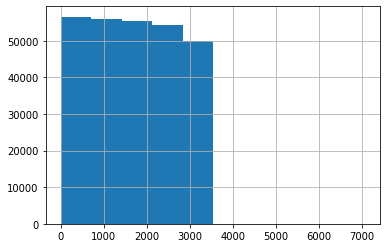

In [43]:
dat['starttime_float'].hist()

In [44]:
dat[dat['starttime_float']>3610]['basename'].drop_duplicates().sort_values().tolist()

['1-254-007.csv', '1-272-003.csv', '1-291-002.csv', '1-296-002.csv']

In [45]:
dat[dat['starttime_float']>3610].groupby(['basename'])['starttime_float'].max()

basename
1-254-007.csv    7080.008264
1-272-003.csv    4019.998265
1-291-002.csv    3899.995865
1-296-002.csv    6179.991464
Name: starttime_float, dtype: float64

In [46]:
dat[dat['starttime_float']>3600].iloc[0]['flow_path']#['starttime_float']

'/ext_ssd/nia_vent/snu/원천_csv/1-250/AWF/1-250-010.csv'

In [47]:
datadf_info = dat

In [48]:
datadf_info

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,patient_id_num,split,basename,wav_firsttime,starttime_float,endtime_float
0,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:00:21.613013+09:00,2021-12-21 16:01:21.613013+09:00,"[[-130.0, -10.0], [-130.0, -10.0], [-130.0, -1...",1,201,10,1-201,626470,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,0.000000,60.000000
1,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:01:21.598746+09:00,2021-12-21 16:02:21.598746+09:00,"[[125.77499389648438, 29.645000457763672], [12...",1,201,10,1-201,626477,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,59.985733,119.985733
2,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:02:21.615413+09:00,2021-12-21 16:03:21.615413+09:00,"[[-14.95000457763672, 6.034999847412109], [-14...",1,201,10,1-201,626485,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,120.002400,180.002400
3,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:03:21.601146+09:00,2021-12-21 16:04:21.601146+09:00,"[[-14.235000610351562, 6.004999160766602], [-1...",1,201,10,1-201,626492,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,179.988133,239.988133
4,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:04:21.617813+09:00,2021-12-21 16:05:21.617813+09:00,"[[-14.7550048828125, 5.944999694824219], [-14....",1,201,10,1-201,626500,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,240.004800,300.004800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272176,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:53:59.992621+09:00,2020-08-07 12:54:59.992621+09:00,"[[629.0, 1947.5], [645.5, 2077.5], [642.5, 215...",2,162,9,2-162,950169,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3240.000648,3300.000648
272177,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:54:59.975978+09:00,2020-08-07 12:55:59.975978+09:00,"[[-289.0, 518.0], [-276.5, 517.0], [-263.0, 51...",2,162,9,2-162,950176,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3299.984005,3359.984005
272178,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:55:59.992645+09:00,2020-08-07 12:56:59.992645+09:00,"[[535.0, 2152.0], [505.0, 2147.0], [473.0, 214...",2,162,9,2-162,950184,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3360.000672,3420.000672
272179,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:56:59.976002+09:00,2020-08-07 12:57:59.976002+09:00,"[[-47.0, 510.0], [-47.0, 510.0], [-47.0, 510.0...",2,162,9,2-162,950191,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3419.984029,3479.984029


In [49]:
dat

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,patient_id_num,split,basename,wav_firsttime,starttime_float,endtime_float
0,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:00:21.613013+09:00,2021-12-21 16:01:21.613013+09:00,"[[-130.0, -10.0], [-130.0, -10.0], [-130.0, -1...",1,201,10,1-201,626470,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,0.000000,60.000000
1,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:01:21.598746+09:00,2021-12-21 16:02:21.598746+09:00,"[[125.77499389648438, 29.645000457763672], [12...",1,201,10,1-201,626477,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,59.985733,119.985733
2,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:02:21.615413+09:00,2021-12-21 16:03:21.615413+09:00,"[[-14.95000457763672, 6.034999847412109], [-14...",1,201,10,1-201,626485,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,120.002400,180.002400
3,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:03:21.601146+09:00,2021-12-21 16:04:21.601146+09:00,"[[-14.235000610351562, 6.004999160766602], [-1...",1,201,10,1-201,626492,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,179.988133,239.988133
4,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:04:21.617813+09:00,2021-12-21 16:05:21.617813+09:00,"[[-14.7550048828125, 5.944999694824219], [-14....",1,201,10,1-201,626500,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,240.004800,300.004800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272176,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:53:59.992621+09:00,2020-08-07 12:54:59.992621+09:00,"[[629.0, 1947.5], [645.5, 2077.5], [642.5, 215...",2,162,9,2-162,950169,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3240.000648,3300.000648
272177,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:54:59.975978+09:00,2020-08-07 12:55:59.975978+09:00,"[[-289.0, 518.0], [-276.5, 517.0], [-263.0, 51...",2,162,9,2-162,950176,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3299.984005,3359.984005
272178,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:55:59.992645+09:00,2020-08-07 12:56:59.992645+09:00,"[[535.0, 2152.0], [505.0, 2147.0], [473.0, 214...",2,162,9,2-162,950184,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3360.000672,3420.000672
272179,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:56:59.976002+09:00,2020-08-07 12:57:59.976002+09:00,"[[-47.0, 510.0], [-47.0, 510.0], [-47.0, 510.0...",2,162,9,2-162,950191,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3419.984029,3479.984029


In [50]:
(dat['basename'].drop_duplicates().isin(ann_df.csv_name)).value_counts()

True     3928
False     997
Name: basename, dtype: int64

In [51]:
ann_df

,startTime,endTime,duration,label_annotation,csv_name,hospital_id_patient_id,wav_number,basename,flow_path,wav_firsttime
0,543.718424,557.139580,13.421156,1,2-105-022.csv,2-105,22,2-105-022.csv,/ext_ssd/nia_vent/aju/2-105/AWF/2-105-022.csv,2019-03-17 20:59:59.998453+09:00
1,1773.633016,1801.868480,28.235464,1,2-105-022.csv,2-105,22,2-105-022.csv,/ext_ssd/nia_vent/aju/2-105/AWF/2-105-022.csv,2019-03-17 20:59:59.998453+09:00
2,548.826835,557.789742,8.962906,1,2-105-022.csv,2-105,22,2-105-022.csv,/ext_ssd/nia_vent/aju/2-105/AWF/2-105-022.csv,2019-03-17 20:59:59.998453+09:00
3,1776.790933,1790.537170,13.746237,1,2-105-022.csv,2-105,22,2-105-022.csv,/ext_ssd/nia_vent/aju/2-105/AWF/2-105-022.csv,2019-03-17 20:59:59.998453+09:00
4,2518.314667,2630.485333,112.170667,1,2-092-001.csv,2-092,1,2-092-001.csv,/ext_ssd/nia_vent/aju/2-092/AWF/2-092-001.csv,2019-07-06 04:59:59.986933+09:00
...,...,...,...,...,...,...,...,...,...,...
53179,3576.004852,3583.988345,7.983493,2,1-213-007.csv,1-213,7,1-213-007.csv,/ext_ssd/nia_vent/snu/원천_csv/1-213/AWF/1-213-0...,2021-12-07 14:00:00.028955+09:00
53180,456.009120,463.992613,7.983493,1,1-273-032.csv,1-273,32,1-273-032.csv,/ext_ssd/nia_vent/snu/원천_csv/1-273/AWF/1-273-0...,2022-05-05 19:59:58.027727+09:00
53181,528.010560,535.994053,7.983493,2,1-245-012.csv,1-245,12,1-245-012.csv,/ext_ssd/nia_vent/snu/원천_csv/1-245/AWF/1-245-0...,2021-11-29 19:00:22.565289+09:00
53182,2336.013386,2343.996879,7.983493,1,1-295-004.csv,1-295,4,1-295-004.csv,/ext_ssd/nia_vent/snu/원천_csv/1-295/AWF/1-295-0...,2022-04-26 11:00:01.411993+09:00


In [52]:
def annotate_each_label(datadf_info, ann_df, label_num:int, 
    instance_time_name=['starttime_float', 'endtime_float'],
    annotation_time_name=['startTime', 'endTime']):
    '''
    datadf_info:  instance data with info
    ann_data: annotation data
    '''
    ist, iend = instance_time_name
    ast, aend = annotation_time_name

    common_keys = ['hospital_id_patient_id','wav_number'] if 'wav_number' in ann_df.columns else ['hospital_id_patient_id']
    ann_data = pd.merge(datadf_info, ann_df[ann_df['label_annotation']==label_num], on=common_keys)
    print('ann_data', ann_data.columns)

    cond1 = (ann_data[ist]<=ann_data[ast])&(ann_data[iend]>=ann_data[aend]) # anntation이 instance 에 포함
    cond2 = (ann_data[ist]<=ann_data[ast])&(ann_data[iend]>=ann_data[ast]) # annotation start가 instance 에 포함
    cond3 = (ann_data[ist]<=ann_data[aend])&(ann_data[iend]>=ann_data[aend]) # annotation end가 instance 에 포함
    ann_index = ann_data[cond1|cond2|cond3]['instance_index']
    return ann_index

def annotate_each_instance(datadf_info, ann_df):
    if 'instance_index' not in datadf_info.columns:
        datadf_info['instance_index'] = range(len(datadf_info))
        print('added instance_index column')
    # print('datadf_info', datadf_info.columns)
    # print('ann_df', ann_df.columns)
    
    ann_index_3 = annotate_each_label(datadf_info, ann_df, 3)
    ann_index_2 = annotate_each_label(datadf_info, ann_df, 2)
    ann_index_1 = annotate_each_label(datadf_info, ann_df, 1)
    print(len(ann_index_1), len(ann_index_2), len(ann_index_3))
    
    datadf_info['label'] = 0
    datadf_info.loc[datadf_info['instance_index'].isin(ann_index_3),'label'] = 3
    datadf_info.loc[datadf_info['instance_index'].isin(ann_index_2),'label'] = 2
    datadf_info.loc[datadf_info['instance_index'].isin(ann_index_1),'label'] = 1
    print(datadf_info.label.value_counts())
    return datadf_info
# datadf_info = datadf_info.loc[:,~datadf_info.columns.isin(['hospital_id','patient_id'])] # aju

In [53]:
# annotation 없는 파형은 제외됨


In [54]:
dat = annotate_each_instance(datadf_info, ann_df)

ann_data Index(['flow_path_x', 'starttime', 'endtime', 'data', 'hospital_id',
       'patient_id', 'wav_number', 'hospital_id_patient_id', 'instance_index',
       'patient_id_num', 'split', 'basename_x', 'wav_firsttime_x',
       'starttime_float', 'endtime_float', 'startTime', 'endTime', 'duration',
       'label_annotation', 'csv_name', 'basename_y', 'flow_path_y',
       'wav_firsttime_y'],
      dtype='object')
ann_data Index(['flow_path_x', 'starttime', 'endtime', 'data', 'hospital_id',
       'patient_id', 'wav_number', 'hospital_id_patient_id', 'instance_index',
       'patient_id_num', 'split', 'basename_x', 'wav_firsttime_x',
       'starttime_float', 'endtime_float', 'startTime', 'endTime', 'duration',
       'label_annotation', 'csv_name', 'basename_y', 'flow_path_y',
       'wav_firsttime_y'],
      dtype='object')
ann_data Index(['flow_path_x', 'starttime', 'endtime', 'data', 'hospital_id',
       'patient_id', 'wav_number', 'hospital_id_patient_id', 'instance_index',
   

In [55]:
len(dat)

272181

In [138]:
# dat_snu = dat.copy()
# del dat

In [ ]:
# dat = pd.concat(dat_snu, dat_aju)

In [56]:
dat

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,patient_id_num,split,basename,wav_firsttime,starttime_float,endtime_float,label
0,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:00:21.613013+09:00,2021-12-21 16:01:21.613013+09:00,"[[-130.0, -10.0], [-130.0, -10.0], [-130.0, -1...",1,201,10,1-201,626470,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,0.000000,60.000000,1
1,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:01:21.598746+09:00,2021-12-21 16:02:21.598746+09:00,"[[125.77499389648438, 29.645000457763672], [12...",1,201,10,1-201,626477,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,59.985733,119.985733,1
2,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:02:21.615413+09:00,2021-12-21 16:03:21.615413+09:00,"[[-14.95000457763672, 6.034999847412109], [-14...",1,201,10,1-201,626485,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,120.002400,180.002400,0
3,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:03:21.601146+09:00,2021-12-21 16:04:21.601146+09:00,"[[-14.235000610351562, 6.004999160766602], [-1...",1,201,10,1-201,626492,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,179.988133,239.988133,0
4,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:04:21.617813+09:00,2021-12-21 16:05:21.617813+09:00,"[[-14.7550048828125, 5.944999694824219], [-14....",1,201,10,1-201,626500,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,240.004800,300.004800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272176,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:53:59.992621+09:00,2020-08-07 12:54:59.992621+09:00,"[[629.0, 1947.5], [645.5, 2077.5], [642.5, 215...",2,162,9,2-162,950169,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3240.000648,3300.000648,0
272177,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:54:59.975978+09:00,2020-08-07 12:55:59.975978+09:00,"[[-289.0, 518.0], [-276.5, 517.0], [-263.0, 51...",2,162,9,2-162,950176,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3299.984005,3359.984005,0
272178,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:55:59.992645+09:00,2020-08-07 12:56:59.992645+09:00,"[[535.0, 2152.0], [505.0, 2147.0], [473.0, 214...",2,162,9,2-162,950184,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3360.000672,3420.000672,0
272179,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:56:59.976002+09:00,2020-08-07 12:57:59.976002+09:00,"[[-47.0, 510.0], [-47.0, 510.0], [-47.0, 510.0...",2,162,9,2-162,950191,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3419.984029,3479.984029,0


In [57]:
(dat['basename'].drop_duplicates().isin(ann_df.csv_name)).value_counts()

True     3928
False     997
Name: basename, dtype: int64

In [58]:
dat_total = dat.copy()

In [59]:
dat = dat[dat['basename'].isin(ann_df.csv_name)]

In [60]:
dat['label'].value_counts()

0    184863
1     26171
2      4249
3      3139
Name: label, dtype: int64

In [61]:
dat['label'].value_counts(normalize=True)

0    0.846357
1    0.119819
2    0.019453
3    0.014371
Name: label, dtype: float64

In [63]:
dat['split'].value_counts()

train    147658
test      53657
valid     17107
Name: split, dtype: int64

In [64]:
dat['split'].value_counts(normalize=True)

train    0.676022
test     0.245657
valid    0.078321
Name: split, dtype: float64

In [62]:
dat[['split','label']].value_counts(normalize=True)

split  label
train  0        0.570547
test   0        0.207113
train  1        0.078811
valid  0        0.068697
test   1        0.033834
train  2        0.015864
       3        0.010800
valid  1        0.007174
test   3        0.002536
       2        0.002175
valid  2        0.001415
       3        0.001035
dtype: float64

In [82]:
dat.groupby(['split'])['hospital_id_patient_id'].nunique()

split
test      25
train    110
valid     15
Name: hospital_id_patient_id, dtype: int64

In [146]:
dat.columns

Index(['flow_path', 'starttime', 'endtime', 'data', 'hospital_id',
       'patient_id', 'wav_number', 'hospital_id_patient_id', 'instance_index',
       'patient_id_num', 'split', 'basename', 'wav_firsttime',
       'starttime_float', 'endtime_float', 'label'],
      dtype='object')

In [158]:
dat.groupby('hospital_id_patient_id')['label'].value_counts(normalize=True).to_frame().rename(columns={'label':'count'}).reset_index(drop=False).groupby('label').describe()

count                                                              \
       count      mean       std       min       25%       50%       75%   
label                                                                      
0      150.0  0.875869  0.087896  0.491525  0.846526  0.903370  0.933020   
1      146.0  0.086226  0.077224  0.008475  0.034425  0.063070  0.103092   
2      132.0  0.020041  0.023490  0.000313  0.008592  0.015409  0.025513   
3      145.0  0.023346  0.049109  0.000806  0.007073  0.011997  0.020183   

                 
            max  
label            
0      1.000000  
1      0.454545  
2      0.211734  
3      0.508475

In [183]:

# # bce_loss = torch.nn.BCELoss(reduction='mean')

# def calculate_vae_loss(out, xi, batch_size=None):
#     bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean')
#     loss_r = bce_loss(out, xi)
#     # loss_r = ((out - xi)**2).sum()
#     loss_kl = torch.mean(.5 * torch.sum(mu.pow(2) + torch.exp(logVar) - 1 - logVar, 1))
#     # loss = torch.mean(loss_r) + loss_kl
#     loss = loss_r + loss_kl
#     return loss, loss_r, loss_kl

# def calculate_bce_loss(out, target, pos_weight=torch.tensor([5])):
#     if pos_weight is not None:
#         pos_weight = pos_weight.to(target)
#     bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)
#     loss = bce_loss(out, target)
#     return loss


In [89]:
nowDate = cutils.get_today_string()

In [90]:
result_path = f'/VOLUME/nia_vent_asynchrony/result/2nd_pat150/train/{nowDate}'
os.makedirs(result_path, exist_ok=True)
print(result_path)

/VOLUME/nia_vent_asynchrony/result/2nd_pat150/train/2022-09-22-02-42-56


In [91]:
labelfreq = pd.concat([dat.groupby('split')['label'].value_counts(),
dat.groupby('split')['label'].value_counts(normalize=True)], axis=1)
labelfreq.columns = ['num', 'ratio']
print(labelfreq)
labelfreq.to_csv(osp.join(result_path, 'label_freq_trainvaltest.csv'))

                num     ratio
split label                  
test  0       45238  0.843096
      1        7390  0.137727
      3         554  0.010325
      2         475  0.008853
train 0      124620  0.843977
      1       17214  0.116580
      2        3465  0.023466
      3        2359  0.015976
valid 0       15005  0.877126
      1        1567  0.091600
      2         309  0.018063
      3         226  0.013211


In [92]:
pd.crosstab(dat['label'].isin([1,2]), dat['split']).to_csv(osp.join(result_path, 'binarylabel_freq_trainvaltest.csv'))

In [68]:
dat

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,patient_id_num,split,basename,wav_firsttime,starttime_float,endtime_float,label
0,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:00:21.613013+09:00,2021-12-21 16:01:21.613013+09:00,"[[-130.0, -10.0], [-130.0, -10.0], [-130.0, -1...",1,201,10,1-201,626470,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,0.000000,60.000000,1
1,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:01:21.598746+09:00,2021-12-21 16:02:21.598746+09:00,"[[125.77499389648438, 29.645000457763672], [12...",1,201,10,1-201,626477,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,59.985733,119.985733,1
2,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:02:21.615413+09:00,2021-12-21 16:03:21.615413+09:00,"[[-14.95000457763672, 6.034999847412109], [-14...",1,201,10,1-201,626485,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,120.002400,180.002400,0
3,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:03:21.601146+09:00,2021-12-21 16:04:21.601146+09:00,"[[-14.235000610351562, 6.004999160766602], [-1...",1,201,10,1-201,626492,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,179.988133,239.988133,0
4,/ext_ssd/nia_vent/snu/원천_csv/1-201/AWF/1-201-0...,2021-12-21 16:04:21.617813+09:00,2021-12-21 16:05:21.617813+09:00,"[[-14.7550048828125, 5.944999694824219], [-14....",1,201,10,1-201,626500,201,train,1-201-010.csv,2021-12-21 16:00:21.613013+09:00,240.004800,300.004800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272176,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:53:59.992621+09:00,2020-08-07 12:54:59.992621+09:00,"[[629.0, 1947.5], [645.5, 2077.5], [642.5, 215...",2,162,9,2-162,950169,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3240.000648,3300.000648,0
272177,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:54:59.975978+09:00,2020-08-07 12:55:59.975978+09:00,"[[-289.0, 518.0], [-276.5, 517.0], [-263.0, 51...",2,162,9,2-162,950176,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3299.984005,3359.984005,0
272178,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:55:59.992645+09:00,2020-08-07 12:56:59.992645+09:00,"[[535.0, 2152.0], [505.0, 2147.0], [473.0, 214...",2,162,9,2-162,950184,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3360.000672,3420.000672,0
272179,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:56:59.976002+09:00,2020-08-07 12:57:59.976002+09:00,"[[-47.0, 510.0], [-47.0, 510.0], [-47.0, 510.0...",2,162,9,2-162,950191,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3419.984029,3479.984029,0


In [138]:
dat[dat['hospital_id']=='1']['flow_path'].drop_duplicates().tolist()[-100:]

['/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-119.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-120.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-121.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-122.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-123.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-124.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-125.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-126.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-127.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-128.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-129.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-130.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-131.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-132.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-133.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-134.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/1-300/AWF/1-300-135.csv',
 '/ext_ssd/nia_vent/snu/원천_csv/

In [188]:
# dat['split']='train'

In [69]:
dat['data'].isna().sum()

0

In [109]:
len(dat[['hospital_id_patient_id','wav_number']].drop_duplicates())

3928

In [70]:
train_dataloader, val_dataloader, test_dataloader = preprocess_data(dat, set_train_weightedsampler=True, scale=True) # 2min

no of train, val, test 147658 17107 53657
x_data (147658, 3600, 2)
trans x_data torch.Size([147658, 2, 3600])
trans y_data torch.Size([147658, 1, 1])
x_data (53657, 3600, 2)
trans x_data torch.Size([53657, 2, 3600])
trans y_data torch.Size([53657, 1, 1])
x_data (17107, 3600, 2)
trans x_data torch.Size([17107, 2, 3600])
trans y_data torch.Size([17107, 1, 1])
X.shape (147658, 3600, 2) (17107, 3600, 2) (53657, 3600, 2)
Y class distribution 0.1400465940619224 0.10966271052982574 0.14657919722202287


In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [98]:
ventdys_model = AsynchModel(input_dim=2, padding_mode='replicate').to(device)

In [99]:
summary(ventdys_model, input_size=(2, 3600), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 3600]             176
       BatchNorm1d-2             [-1, 16, 3600]              32
              ReLU-3             [-1, 16, 3600]               0
         MaxPool1d-4              [-1, 16, 900]               0
            Conv1d-5              [-1, 32, 900]           2,592
       BatchNorm1d-6              [-1, 32, 900]              64
              ReLU-7              [-1, 32, 900]               0
         MaxPool1d-8              [-1, 32, 225]               0
            Conv1d-9              [-1, 32, 225]           5,152
      BatchNorm1d-10              [-1, 32, 225]              64
             ReLU-11              [-1, 32, 225]               0
        MaxPool1d-12               [-1, 32, 56]               0
           Conv1d-13               [-1, 64, 56]          10,304
      BatchNorm1d-14               [-1,

In [110]:
result_path

'/VOLUME/nia_vent_asynchrony/result/2nd_pat150/train/2022-09-22-02-42-56'

In [100]:
n_epochs = 50
learning_rate = 1e-3
optimizer = torch.optim.Adam(ventdys_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience = 10, verbose = True, path = result_path, checkpoint_name='ventdys_model.pt')


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
# 모델이 학습되는 동안 trainning loss를 track
train_losses = []
# 모델이 학습되는 동안 validation loss를 track
valid_losses = []
# epoch당 average training loss를 track
avg_train_losses = []
# epoch당 average validation loss를 track
avg_valid_losses = []


for epoch in range(n_epochs):
    print('[Timestamp:', cutils.get_today_string(),']')
    print(f'Epoch {epoch}')

    ventdys_model.train()
    for i_step, data in enumerate(train_dataloader):
        xi, target = data
        xi = xi.to(device)
        target = target.to(device).squeeze(-1).squeeze(-1).float()
        out = ventdys_model(xi)

        loss = calculate_bce_loss(out[:,1], target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # print('step', i_step, 'loss', loss.item())
    print('epoch', epoch, 'loss', loss.item())
    
    ######################    
    # validate the model #
    ######################
    ventdys_model.eval() # prep model for evaluation
    # y_prob = None
    # y_target = None
    for i_step, data in enumerate(val_dataloader) :
        xi, target = data
        xi = xi.to(device)
        batch_size = len(xi)
        target = target.to(device).squeeze(-1).squeeze(-1).float()
        out = ventdys_model(xi)
        loss = calculate_bce_loss(out[:,1], target)
        
        valid_losses.append(loss.item())


    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
        
    epoch_len = len(str(n_epochs))


    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')

    print(print_msg)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []

    early_stopping(valid_loss, ventdys_model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# 12 min

[Timestamp: 2022-09-22-02-51-46 ]
Epoch 0
epoch 0 loss 0.9796514511108398
[ 0/50] train_loss: 1.03825 valid_loss: 1.38660
Validation loss decreased (inf --> 1.386600).  Saving model ...
[Timestamp: 2022-09-22-02-52-08 ]
Epoch 1
epoch 1 loss 0.9289920926094055
[ 1/50] train_loss: 0.92708 valid_loss: 0.90270
Validation loss decreased (1.386600 --> 0.902704).  Saving model ...
[Timestamp: 2022-09-22-02-52-30 ]
Epoch 2
epoch 2 loss 0.9487566947937012
[ 2/50] train_loss: 0.86867 valid_loss: 0.91902
EarlyStopping counter: 1 out of 10
[Timestamp: 2022-09-22-02-52-52 ]
Epoch 3
epoch 3 loss 0.7867882251739502
[ 3/50] train_loss: 0.86940 valid_loss: 0.80460
Validation loss decreased (0.902704 --> 0.804604).  Saving model ...
[Timestamp: 2022-09-22-02-53-14 ]
Epoch 4
epoch 4 loss 0.9164487719535828
[ 4/50] train_loss: 0.85614 valid_loss: 1.06262
EarlyStopping counter: 1 out of 10
[Timestamp: 2022-09-22-02-53-36 ]
Epoch 5
epoch 5 loss 1.0765912532806396
[ 5/50] train_loss: 0.84044 valid_loss: 0.76

In [101]:
epoch

21

In [102]:
# predict testset 
ventdys_model.eval()

y_prob = None
for i_step, data in enumerate(test_dataloader):
    xi, target = data
    xi = xi.to(device)
    target = target.to(device).squeeze(-1).squeeze(-1).float() # torch.Size([bs, 1])
    out = ventdys_model(xi)

    
    loss = calculate_bce_loss(out[:,1], target)

    prob = F.softmax(out, dim=1)[:,1].detach().cpu()
    # pred = y_proba>0.5
    y_prob = prob if y_prob is None else torch.cat([y_prob, prob])

    # pred_list.append(out.detach().cpu().numpy())
    if i_step%1000==0: print('step', i_step, 'loss', loss.item())


step 0 loss 1.172296166419983


In [103]:
testset = test_dataloader.dataset

In [104]:
# 아마 /VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-23-09-40-08/checkpoint.pt
# testset_target = abnomal_testset.y_data.squeeze(-1).float()
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
test_perf = calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.5)
test_perf

{'auroc': 0.88,
 'auprc': 0.58,
 'prec': 0.33,
 'recall': 0.91,
 'f1': 0.48,
 'f2': 0.67,
 'specificity': 0.68,
 'tn': 31193.0,
 'fp': 14599.0,
 'fn': 740.0,
 'tp': 7125.0,
 'auprcf1': 1.07}

In [167]:
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
test_perf = calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.9)
test_perf

{'auroc': 0.88,
 'auprc': 0.58,
 'prec': 0.51,
 'recall': 0.7,
 'f1': 0.59,
 'f2': 0.65,
 'specificity': 0.88,
 'tn': 40468.0,
 'fp': 5324.0,
 'fn': 2388.0,
 'tp': 5477.0,
 'auprcf1': 1.17}

In [105]:
perc =  [.05, .1 , .25, .5, .75, .9, .95]
percentile = pd.DataFrame(np.percentile(y_prob, perc).reshape(1, -1), columns=perc, index=['y_prob'])
percentile.to_csv(osp.join(result_path, 'y_prob_percentile.csv'))
percentile

,0.05,0.10,0.25,0.50,0.75,0.90,0.95
y_prob,0.000124,0.003555,0.004216,0.004935,0.005492,0.005853,0.005953


<AxesSubplot:>

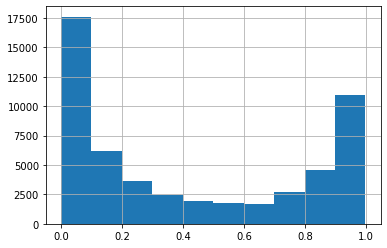

In [106]:
pd.Series(y_prob).hist()

In [107]:
np.sum(test_perf[i] for i in ['tn','tp','fn','fp'])

53657.0

In [108]:
test_perf.update({'total_number': np.sum(test_perf[i] for i in ['tn','tp','fn','fp'])})
pd.DataFrame(test_perf, index=['testset']).to_csv(osp.join(result_path, 'test_set_performance.csv'))

testset의 예측=1 인 metainfo 찾아서 그리기
label 있으면 표시하기
파일명: 

In [38]:
ckpt_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-24-04-29-23/ventdys_model.pt'
ckpt_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-26-10-32-15/ventdys_model.pt'
ckpt_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-09-19-07-34-07/ventdys_model.pt'
ckpt_dict = torch.load(ckpt_path)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [40]:
ventdys_model = AsynchModel(input_dim=2, padding_mode='replicate').to(device)
ventdys_model.load_state_dict(ckpt_dict, strict=False)

<All keys matched successfully>

In [ ]:
dat_infer = pd.concat([pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_723989_2022-08-26.pkl'),
    pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_519403_2022-08-26.pkl')
])

In [49]:
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_3145286_2022-08-25.pkl')

dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_aju_2-001_2-099_2582998_2022-09-02.pkl')
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_aju_2-100_2-249_3160686_2022-09-03.pkl')# 92~162는 1차라 제외

# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_1-001_1-099_7382836_2022-09-03.pkl') # TODO
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_1-100_1-177_4972675_2022-09-03.pkl') # 4972675 rows 메모리 떄문에 한번에 못돌림
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_1-178_1-379_1953563_2022-09-02.pkl') # 201~300은 1차라 제외 

# 5m

In [ ]:
# dat_infer = dat_infer[dat_infer['patient_id'].astype(int)>25]
# dat_infer = dat_infer[dat_infer['patient_id'].astype(int)<40]

In [118]:
del dat_infer_bak

In [50]:
plist = dat_infer['hospital_id_patient_id'].drop_duplicates().sort_values().tolist()
print(len(plist))

70


In [117]:
print(len(plist))
# plist = plist[:100]
# plist = plist[50:]
print(len(plist))
dat_infer = dat_infer[dat_infer['hospital_id_patient_id'].isin(plist)]

70
70


In [51]:
dat_infer['hospital_id_patient_id'].min(), dat_infer['hospital_id_patient_id'].max(), dat_infer['hospital_id_patient_id'].nunique()

('2-001', '2-099', 70)

In [ ]:
dat_infer[[]]

In [53]:
dat_infer

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id
0,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 21:59:59.999173+09:00,2019-05-18 22:00:07.982508+09:00,"[[-71.5, 493.5], [-59.0, 481.0], [-46.5, 478.5...",2,065,70,2-065
1,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 22:00:07.999174+09:00,2019-05-18 22:00:15.982509+09:00,"[[-41.0, 514.0], [-39.0, 503.0], [-32.5, 485.5...",2,065,70,2-065
2,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 22:00:15.999176+09:00,2019-05-18 22:00:23.982511+09:00,"[[-24.0, 529.0], [-24.0, 526.0], [-23.5, 522.0...",2,065,70,2-065
3,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 22:00:23.999178+09:00,2019-05-18 22:00:31.982513+09:00,"[[-172.0, 529.0], [-163.5, 526.0], [-156.5, 52...",2,065,70,2-065
4,/ext_ssd/nia_vent/aju/2-065/AWF/2-065-070.csv,2019-05-18 22:00:31.999179+09:00,2019-05-18 22:00:39.982514+09:00,"[[-16.0, 516.0], [-16.0, 511.5], [-16.0, 513.5...",2,065,70,2-065
...,...,...,...,...,...,...,...,...
444,/ext_ssd/nia_vent/aju/2-086/AWF/2-086-020.csv,2020-03-07 13:59:11.993403+09:00,2020-03-07 13:59:19.976738+09:00,"[[-48.0, 797.5], [-38.5, 790.0], [-33.5, 790.0...",2,086,20,2-086
445,/ext_ssd/nia_vent/aju/2-086/AWF/2-086-020.csv,2020-03-07 13:59:19.993405+09:00,2020-03-07 13:59:27.976740+09:00,"[[885.0, 1346.0], [957.0, 1370.0], [1009.0, 14...",2,086,20,2-086
446,/ext_ssd/nia_vent/aju/2-086/AWF/2-086-020.csv,2020-03-07 13:59:27.993406+09:00,2020-03-07 13:59:35.976741+09:00,"[[-100.5, 795.0], [-98.0, 791.0], [-103.0, 795...",2,086,20,2-086
447,/ext_ssd/nia_vent/aju/2-086/AWF/2-086-020.csv,2020-03-07 13:59:35.993408+09:00,2020-03-07 13:59:43.976743+09:00,"[[189.5, 1421.0], [181.0, 1425.0], [173.0, 142...",2,086,20,2-086


In [134]:
    # dat_infer = 
    dat_infer[~dat_infer['hospital_id_patient_id'].isin(dat_list_bak)]['hospital_id_patient_id'].nunique()

0

In [54]:
    # dat_list_bak = dat_infer[['hospital_id_patient_id','wav_number']].drop_duplicates()
    
    patwav_df = dat_infer[['hospital_id_patient_id','wav_number']].drop_duplicates()
    print(len(patwav_df), 'patwav_df')
    # patwav_df = patwav_df.iloc[6000:]
    # dat_infer = dat_infer[dat_infer['hospital_id_patient_id'].isin(patwav_df['hospital_id_patient_id'])]

6058 patwav_df


In [57]:
patwav_df.groupby('hospital_id_patient_id').count().to_csv(dest_dir+'/../tmp_2-001_2-099_wav_num_220920-1729.csv')

In [6]:
done_list = glob.glob(f'{dest_dir}/*.pkl')

In [7]:
len(done_list)

43399

In [9]:
done_df = pd.DataFrame({'path': done_list})
done_df['filename'] = done_df['path'].copy().str.replace(dest_dir+'/', '')
done_df = pd.concat([done_df, 
    done_df['filename'].str.split('_').apply(pd.Series).rename(columns={0: 'hospital_id_patient_id', 1: 'wav_number', 2: 'datetime'})], axis=1)

In [58]:
done_df[['hospital_id_patient_id','wav_number']].duplicated().sum()

1536

In [34]:
done_df[done_df[['hospital_id_patient_id','wav_number']].duplicated(keep=False)]#.sort_values(['hospital_id_patient_id','wav_number'])

,path,filename,hospital_id_patient_id,wav_number,datetime
376,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-104_1_2022-09-19.pkl,1-104,1,2022-09-19.pkl
35124,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-104_1_2022-09-20.pkl,1-104,1,2022-09-20.pkl
355,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-104_10_2022-09-19.pkl,1-104,10,2022-09-19.pkl
35103,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-104_10_2022-09-20.pkl,1-104,10,2022-09-20.pkl
358,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-104_11_2022-09-19.pkl,1-104,11,2022-09-19.pkl
...,...,...,...,...,...
23486,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-237_97_2022-09-20.pkl,2-237,97,2022-09-20.pkl
22613,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-237_98_2022-09-19.pkl,2-237,98,2022-09-19.pkl
23615,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-237_98_2022-09-20.pkl,2-237,98,2022-09-20.pkl
22624,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-237_99_2022-09-19.pkl,2-237,99,2022-09-19.pkl


In [31]:
dest_dir

'/VOLUME/nia_vent_asynchrony/data/processed_data/tmp'

In [38]:
 done_df['hospital_id_patient_id'].str[2:]

13247    001
13248    001
13249    001
13251    001
13245    001
        ... 
26152    249
26013    249
26240    249
26120    249
26132    249
Name: hospital_id_patient_id, Length: 43399, dtype: object

In [41]:
done_df = done_df.sort_values(['hospital_id_patient_id','wav_number','datetime'])
done_df['patient_id'] = done_df['hospital_id_patient_id'].str[2:]
done_df['patient_id_num'] = done_df['patient_id'].astype(int)
unique_done_df = done_df.groupby(['hospital_id_patient_id','wav_number']).tail(1)

In [45]:
dest_dir

'/VOLUME/nia_vent_asynchrony/data/processed_data/tmp'

In [46]:
unique_done_df.groupby(['hospital_id_patient_id']).count().to_csv('/VOLUME/nia_vent_asynchrony/data/processed_data/tmp_done_list_220920-1709.csv')

In [37]:
unique_done_df

,path,filename,hospital_id_patient_id,wav_number,datetime
13247,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_1_2022-09-19.pkl,1-001,1,2022-09-19.pkl
13248,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_2_2022-09-19.pkl,1-001,2,2022-09-19.pkl
13249,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_3_2022-09-19.pkl,1-001,3,2022-09-19.pkl
13251,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_4_2022-09-19.pkl,1-001,4,2022-09-19.pkl
13245,/VOLUME/nia_vent_asynchrony/data/processed_dat...,1-001_5_2022-09-19.pkl,1-001,5,2022-09-19.pkl
...,...,...,...,...,...
26152,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_95_2022-09-20.pkl,2-249,95,2022-09-20.pkl
26013,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_96_2022-09-20.pkl,2-249,96,2022-09-20.pkl
26240,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_97_2022-09-20.pkl,2-249,97,2022-09-20.pkl
26120,/VOLUME/nia_vent_asynchrony/data/processed_dat...,2-249_98_2022-09-20.pkl,2-249,98,2022-09-20.pkl


In [48]:
unique_done_df['path'].iloc[0]

'/VOLUME/nia_vent_asynchrony/data/processed_data/tmp/1-001_1_2022-09-19.pkl'

In [140]:
ls = []
for i, row in patwav_df.iterrows():
    files = glob.glob(f'{dest_dir}/{row["hospital_id_patient_id"]}_{row["wav_number"]}_*.pkl')
    if len(files)==0:
        ls.append(row)

In [ ]:
dat_infer = dat_infer[dat_infer['hospital_id_patient_id']=='2-089']

In [ ]:
_ = merge_data(dat_infer)
# 4500 instance , 10threads, 70min
# 6000 instance , 10threads, 142min

79 patwav_df
0 449


In [5]:
dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_aju_2-100_2-249_3160686_2022-09-03.pkl')# 92~162는 1차라 제외


In [6]:
# dat_infer = dat_infer[(dat_infer['patient_id'].astype(int)>162)|(dat_infer['patient_id'].astype(int)<92)]

In [7]:
_ = merge_data(dat_infer)
# 4882 patwav_df, 21min

4882 patwav_df
0 449
100 149
200 449
300 449
400 224
500 449
600 449
700 449
800 449
900 449
1000 449
1100 449
1200 449
1300 449
1400 449
1500 449
1600 449
1700 449
1800 449
1900 449
2000 449
2100 449
2200 449
2300 449
2400 449
2500 449
2600 449
2700 449
2800 449
2900 449
3000 449
3100 74
3200 449
3300 449
3400 449
3500 449
3600 449
3700 449
3800 449
3900 449
4000 449
4100 449
4200 449
4300 449
4400 449
4500 449
4600 225
4700 449
4800 449


In [8]:
dat_infer

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index
0,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 00:59:59.984053+09:00,2020-11-28 01:00:07.967388+09:00,"[[-87.0, 799.0], [-79.5, 812.5], [-68.5, 830.5...",2,217,27,2-217,0
1,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:07.984054+09:00,2020-11-28 01:00:15.967389+09:00,"[[-163.5, 864.0], [-157.5, 856.0], [-151.5, 84...",2,217,27,2-217,1
2,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:15.984056+09:00,2020-11-28 01:00:23.967391+09:00,"[[-29.0, 861.0], [-30.5, 861.0], [-31.5, 861.0...",2,217,27,2-217,2
3,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:23.984058+09:00,2020-11-28 01:00:31.967393+09:00,"[[683.0, 1393.0], [738.0, 1485.0], [792.5, 157...",2,217,27,2-217,3
4,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:31.984059+09:00,2020-11-28 01:00:39.967394+09:00,"[[309.5, 1038.0], [460.5, 1198.0], [612.0, 135...",2,217,27,2-217,4
...,...,...,...,...,...,...,...,...,...
444,/ext_ssd/nia_vent/aju/2-209/AWF/2-209-006.csv,2020-09-18 01:59:11.984763+09:00,2020-09-18 01:59:19.968098+09:00,"[[407.0, 1066.0], [400.5, 1063.5], [396.5, 105...",2,209,6,2-209,2096348
445,/ext_ssd/nia_vent/aju/2-209/AWF/2-209-006.csv,2020-09-18 01:59:19.984765+09:00,2020-09-18 01:59:27.968100+09:00,"[[123.0, 855.0], [109.5, 855.0], [84.0, 839.5]...",2,209,6,2-209,2096349
446,/ext_ssd/nia_vent/aju/2-209/AWF/2-209-006.csv,2020-09-18 01:59:27.984766+09:00,2020-09-18 01:59:35.968101+09:00,"[[-254.5, 607.0], [-260.5, 607.0], [-265.0, 60...",2,209,6,2-209,2096350
447,/ext_ssd/nia_vent/aju/2-209/AWF/2-209-006.csv,2020-09-18 01:59:35.984768+09:00,2020-09-18 01:59:43.968103+09:00,"[[-130.5, 562.0], [-132.5, 562.0], [-134.5, 56...",2,209,6,2-209,2096351


In [10]:
dat_infer['hospital_id_patient_id'].nunique()

35

In [20]:
flist = []
for idx in dat_infer['hospital_id_patient_id'].drop_duplicates():
    flist.extend(glob.glob(os.path.join(dest_dir, f'{idx}_*')))

dat = []
for fn in flist:
    dat.append(pd.read_pickle(fn))
dat = pd.concat(dat)
dat['wav_number'] = dat['wav_number'].astype(int)

In [24]:
dat

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index
0,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 00:59:59.984053+09:00,2020-11-28 01:00:59.984053+09:00,"[[-87.0, 799.0], [-79.5, 812.5], [-68.5, 830.5...",2,217,27,2-217,0
7,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:00:59.967410+09:00,2020-11-28 01:01:59.967410+09:00,"[[-247.5, 880.5], [-230.5, 878.5], [-217.5, 87...",2,217,27,2-217,7
15,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:01:59.984077+09:00,2020-11-28 01:02:59.984077+09:00,"[[324.0, 2193.0], [297.5, 2181.0], [271.5, 216...",2,217,27,2-217,15
22,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:02:59.967434+09:00,2020-11-28 01:03:59.967434+09:00,"[[338.0, 2127.5], [307.5, 2118.0], [285.5, 211...",2,217,27,2-217,22
30,/ext_ssd/nia_vent/aju/2-217/AWF/2-217-027.csv,2020-11-28 01:03:59.984101+09:00,2020-11-28 01:04:59.984101+09:00,"[[-118.0, 858.5], [-117.0, 856.5], [-115.5, 85...",2,217,27,2-217,30
...,...,...,...,...,...,...,...,...,...
405,/ext_ssd/nia_vent/aju/2-209/AWF/2-209-006.csv,2020-09-18 01:53:59.984701+09:00,2020-09-18 01:54:59.984701+09:00,"[[-129.0, 562.0], [-129.0, 562.0], [-129.0, 55...",2,209,6,2-209,2096309
412,/ext_ssd/nia_vent/aju/2-209/AWF/2-209-006.csv,2020-09-18 01:54:59.968058+09:00,2020-09-18 01:55:59.968058+09:00,"[[-18.0, 519.5], [-17.0, 517.5], [-16.5, 519.5...",2,209,6,2-209,2096316
420,/ext_ssd/nia_vent/aju/2-209/AWF/2-209-006.csv,2020-09-18 01:55:59.984725+09:00,2020-09-18 01:56:59.984725+09:00,"[[-126.0, 568.0], [-129.5, 568.0], [-133.0, 57...",2,209,6,2-209,2096324
427,/ext_ssd/nia_vent/aju/2-209/AWF/2-209-006.csv,2020-09-18 01:56:59.968082+09:00,2020-09-18 01:57:59.968082+09:00,"[[-192.5, 565.0], [-189.5, 562.0], [-187.0, 56...",2,209,6,2-209,2096331


In [25]:
dat_infer = dat

In [26]:
dat_infer['hospital_id_patient_id'].min(), dat_infer['hospital_id_patient_id'].max(), dat_infer['hospital_id_patient_id'].nunique()

('2-163', '2-249', 35)

In [ ]:
# dat['instance_index'] = range(len(dat))

In [ ]:
# dest_path = f'/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_{dat_infer["hospital_id_patient_id"].min()}_{dat_infer["hospital_id_patient_id"].max()}_{len(dat_infer)}_{cutils.get_today_string(False)}.pkl'
# dat_infer.to_pickle(dest_path)

In [ ]:
dest_path

In [28]:
len(dat_infer)

315386

In [29]:
dat_infer['hospital_id_patient_id'].nunique()

35

In [ ]:
# dat_infer['hospital_id_patient_id'].drop_duplicates().sort_values().tolist()

In [30]:
dat_infer['split'] = 'test'

In [ ]:
# dat_infer_bak = dat_infer.copy()
# dat_infer = dat_infer_bak

In [ ]:
# dat_infer = dat_infer.iloc[6000000:,:]
# dat_infer = dat_infer.iloc[:700000,:]

In [31]:
len(dat_infer)

315386

In [32]:
# testset = ...
_, _, test_dataloader = preprocess_data(dat_infer, scale=True)
# 315386 rows, elapsed 5min

no of train, val, test 0 0 315386
x_data (315386, 3600, 2)
trans x_data torch.Size([315386, 2, 3600])
trans y_data torch.Size([315386, 1, 1])
X.shape (0, 3600, 2) (315386, 3600, 2)
Y class distribution 0.0 0.0


In [41]:
# predict testset 
ventdys_model.eval()

y_prob = None
for i_step, data in enumerate(test_dataloader):
    xi, target = data
    xi = xi.to(device)
    target = target.to(device).squeeze(-1).squeeze(-1).float() # torch.Size([bs, 1])
    out = ventdys_model(xi)

    
    loss = calculate_bce_loss(out[:,1], target)

    prob = F.softmax(out, dim=1)[:,1].detach().cpu()
    # pred = y_proba>0.5
    y_prob = prob if y_prob is None else torch.cat([y_prob, prob])

    # pred_list.append(out.detach().cpu().numpy())
    if i_step%1000==0: print('step', i_step, 'loss', loss.item())


step 0 loss -3.0853954338929246e+19


In [42]:
testset = test_dataloader.dataset

In [ ]:
# test_metainfo = testset.metainfo
# test_metainfo

In [118]:
testset_pred = testset.metainfo
testset_pred['y_pred_prob'] = y_prob
testset_pred['y_pred'] = y_prob>0.99
if 'label' in testset_pred.columns:
    testset_pred['y_target'] = testset_pred['label'].isin([2,1])

In [119]:
testset_pred

,flow_path,starttime,endtime,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,patient_id_num,split,basename,wav_firsttime,starttime_float,endtime_float,label,y_pred_prob,y_pred,y_target
90217,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 16:59:57.719324+09:00,2022-03-25 17:00:57.719324+09:00,1,291,10,1-291,91258,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,0.000000,60.000000,1,0.916615,False,True
90218,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 17:00:57.705057+09:00,2022-03-25 17:01:57.705057+09:00,1,291,10,1-291,91265,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,59.985733,119.985733,1,0.914168,False,True
90219,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 17:01:57.721724+09:00,2022-03-25 17:02:57.721724+09:00,1,291,10,1-291,91273,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,120.002400,180.002400,2,0.926924,False,True
90220,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 17:02:57.707457+09:00,2022-03-25 17:03:57.707457+09:00,1,291,10,1-291,91280,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,179.988133,239.988133,0,0.922406,False,False
90221,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 17:03:57.724124+09:00,2022-03-25 17:04:57.724124+09:00,1,291,10,1-291,91288,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,240.004800,300.004800,0,0.080786,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272176,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:53:59.992621+09:00,2020-08-07 12:54:59.992621+09:00,2,162,9,2-162,950169,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3240.000648,3300.000648,0,0.008830,False,False
272177,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:54:59.975978+09:00,2020-08-07 12:55:59.975978+09:00,2,162,9,2-162,950176,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3299.984005,3359.984005,0,0.011006,False,False
272178,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:55:59.992645+09:00,2020-08-07 12:56:59.992645+09:00,2,162,9,2-162,950184,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3360.000672,3420.000672,0,0.007047,False,False
272179,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:56:59.976002+09:00,2020-08-07 12:57:59.976002+09:00,2,162,9,2-162,950191,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3419.984029,3479.984029,0,0.009737,False,False


In [120]:
testset_pred['hospital_id_patient_id'].unique()

array(['1-291', '1-292', '1-293', '1-294', '1-295', '1-296', '1-297',
       '1-298', '1-299', '1-300', '2-139', '2-140', '2-141', '2-143',
       '2-145', '2-146', '2-147', '2-148', '2-151', '2-154', '2-156',
       '2-157', '2-158', '2-159', '2-162'], dtype=object)

In [121]:
# testset_pred = testset_pred_bak

In [122]:
# testset_pred = pd.concat([testset_pred, testset_pred_bak])

In [123]:
# testset_pred = testset_pred_bak

In [124]:
# testset_pred_bak = testset_pred.copy()

In [125]:
perc =  [.05, .1 , .25, .5, .75, .9, .95, .99, .999]
percentile = pd.DataFrame(np.percentile(testset_pred['y_pred_prob'], perc).reshape(1, -1), columns=perc, index=['y_prob'])
percentile

,0.050,0.100,0.250,0.500,0.750,0.900,0.950,0.990,0.999
y_prob,0.000124,0.003555,0.004216,0.004935,0.005492,0.005853,0.005953,0.006048,0.00606


<AxesSubplot:>

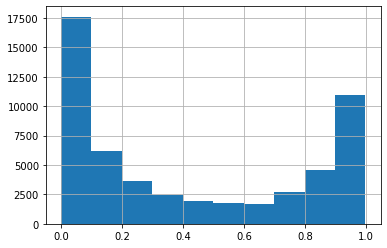

In [126]:
testset_pred['y_pred_prob'].hist()

In [127]:
testset_pred['y_pred'].value_counts()

False    53157
True       500
Name: y_pred, dtype: int64

In [128]:
testset_pred['y_pred'].value_counts(normalize=True)

False    0.990682
True     0.009318
Name: y_pred, dtype: float64

In [129]:
testset_pred

,flow_path,starttime,endtime,hospital_id,patient_id,wav_number,hospital_id_patient_id,instance_index,patient_id_num,split,basename,wav_firsttime,starttime_float,endtime_float,label,y_pred_prob,y_pred,y_target
90217,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 16:59:57.719324+09:00,2022-03-25 17:00:57.719324+09:00,1,291,10,1-291,91258,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,0.000000,60.000000,1,0.916615,False,True
90218,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 17:00:57.705057+09:00,2022-03-25 17:01:57.705057+09:00,1,291,10,1-291,91265,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,59.985733,119.985733,1,0.914168,False,True
90219,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 17:01:57.721724+09:00,2022-03-25 17:02:57.721724+09:00,1,291,10,1-291,91273,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,120.002400,180.002400,2,0.926924,False,True
90220,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 17:02:57.707457+09:00,2022-03-25 17:03:57.707457+09:00,1,291,10,1-291,91280,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,179.988133,239.988133,0,0.922406,False,False
90221,/ext_ssd/nia_vent/snu/원천_csv/1-291/AWF/1-291-0...,2022-03-25 17:03:57.724124+09:00,2022-03-25 17:04:57.724124+09:00,1,291,10,1-291,91288,291,test,1-291-010.csv,2022-03-25 16:59:57.719324+09:00,240.004800,300.004800,0,0.080786,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272176,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:53:59.992621+09:00,2020-08-07 12:54:59.992621+09:00,2,162,9,2-162,950169,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3240.000648,3300.000648,0,0.008830,False,False
272177,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:54:59.975978+09:00,2020-08-07 12:55:59.975978+09:00,2,162,9,2-162,950176,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3299.984005,3359.984005,0,0.011006,False,False
272178,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:55:59.992645+09:00,2020-08-07 12:56:59.992645+09:00,2,162,9,2-162,950184,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3360.000672,3420.000672,0,0.007047,False,False
272179,/ext_ssd/nia_vent/aju/2-162/AWF/2-162-009.csv,2020-08-07 12:56:59.976002+09:00,2020-08-07 12:57:59.976002+09:00,2,162,9,2-162,950191,162,test,2-162-009.csv,2020-08-07 11:59:59.991973+09:00,3419.984029,3479.984029,0,0.009737,False,False


In [130]:
testset_pred['hospital_id_patient_id'].min()+'_'+testset_pred['hospital_id_patient_id'].max()

'1-291_2-162'

In [131]:
result_path = '/VOLUME/nia_vent_asynchrony/result/2nd_pat150/infer'

In [134]:
path = osp.join(result_path, f'testset_{testset_pred["hospital_id_patient_id"].min()+"_"+testset_pred["hospital_id_patient_id"].max()}_{len(testset_pred)}_pred_{cutils.get_today_string(False)}.csv')
testset_pred.to_csv(path)
path

'/VOLUME/nia_vent_asynchrony/result/2nd_pat150/infer/testset_1-291_2-162_53657_pred_2022-09-22.csv'

prediction 합치기

In [ ]:
fn = glob.glob(result_path+'/test*_tmp*')
ls = []
for fi in fn:
    ls.append(pd.read_csv(fi, index_col=0))

In [ ]:
testset_pred = pd.concat(ls)

In [ ]:
testset_pred['hospital_id_patient_id'].nunique()

In [ ]:
testset_pred['hospital_id_patient_id'].min()

In [ ]:
testset_pred['hospital_id_patient_id'].max()

In [ ]:
testset_pred['conf_matrix'] = ''
testset_pred.loc[(testset_pred['y_target'])&(testset_pred['y_pred']),'conf_matrix']='tp'
testset_pred.loc[(~testset_pred['y_target'])&(testset_pred['y_pred']),'conf_matrix']='fp'
testset_pred.loc[(testset_pred['y_target'])&(~testset_pred['y_pred']),'conf_matrix']='fn'
testset_pred.loc[(~testset_pred['y_target'])&(~testset_pred['y_pred']),'conf_matrix']='tn'

In [ ]:
pd.crosstab(testset_pred['y_pred'], testset_pred['label'].isin([2,1]))

In [ ]:
pd.crosstab(testset_pred['y_pred'], testset_pred['label'])

In [ ]:
testset_pred['conf_matrix'].value_counts()

In [ ]:
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.5)

In [ ]:
pd.Series(y_prob).hist()

In [ ]:
dat

In [ ]:
dat['hospital_id_patient_id'].str[0]

In [ ]:
dat['data'].head().apply(lambda x: np.nanmedian(x, axis=0))